### Overview
This notebook reads a pre-processed set of English questions from Kenya, removes stopwords, tokenizes the questions for future NLP activities

### Inputs: (files are in working directory)
* CSV files of cleaned / lower case /  punctuation removed questions: 'kenya_eng_q_clean.csv'  

### Output files (in working directory)
* CSV file of tokens:  'ken_eng_tokens.csv'
* CSV file of top 500 bigrams: 'ken_eng_bigrams_top500.csv'
* CSV file of top 500 trigrams:  'ken_eng_trigrams_top500.csv'
* TXT file of top 500 bigrams:  'ken_eng_bigrams_top500.txt'
* TXT file of top 500 trigrams:  'ken_eng_trigrams_top500.txt'                                                                                                                   
* TXT file of top 500 quadgrams:  'ken_eng_quadgrams_top500.txt'
* PNG file of static network diagram of top 40 bigrams: 'top40bigrams_ken_eng_network.png'
* PNG file of static network diagram of top 30 trigrams:'top30trigrams_ken_eng_network.png'                                                                                                                         

### Steps:
1. Remove stopwords
2. Tokenize - takes ~ 10-20 min to run
3. Create english bigrams, trigrams, & quadgrams; save as csv files
4. Plot frequency distribution of top 20 english bigrams, trigrams, & quadgrams
5. Plot static network graphs of top 40 english bigrams and trigrams
                                                                                                                           

In [2]:
#import packages:  pandas, numpy,nltk, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')


from nltk import pos_tag
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

from collections import Counter

import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       d

In [3]:
#load processed country question file
q_df = pd.read_csv('kenya_eng_q_clean.csv')
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384774 entries, 0 to 1384773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1384774 non-null  int64 
 1   question_id     1384774 non-null  int64 
 2   question_topic  1083079 non-null  object
 3   question_clean  1384774 non-null  object
dtypes: int64(2), object(2)
memory usage: 42.3+ MB


In [4]:
#create list of questions:  
ken_q_list=list(q_df['question_clean'])
ken_q_list[0:5]

['  which plant has omega ',
 'what are the effects of animal waste on potato if aplied during planting ',
 ' how much is price of kg of onions farmgate price ',
 ' what is the iron of hens ',
 ' what ìs the  best sesion  for planting pasion fruit  ']

In [5]:
# define function to tokenize, normalize vergs & strings ... with help from ChatGPT

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# map POS tags to WordNet's POS
def get_wordnet_pos(tag):
    if tag.startswith('N'): 
        return wordnet.NOUN
    elif tag.startswith('V'): 
        return wordnet.VERB
    elif tag.startswith('J'): 
        return wordnet.ADJ
    elif tag.startswith('R'): 
        return wordnet.ADV
    else:
        return None

def normalize_strings_list(strings_list):
    """
    Input: list of strings, already lower-case
    Output: list of normalized token lists
    """

    normalized = []

    for text in strings_list:
        # tokenize
        tokens = word_tokenize(text)

        # remove stopwords and non-alphabetic tokens
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

        # pos-tag tokens
        tags = pos_tag(tokens)

        # lemmatize nouns (plural→singular), verbs (tense normalization), etc.
        lemmatized = []
        for word, tag in tags:
            wn_pos = get_wordnet_pos(tag)
            if wn_pos:
                lemma = lemmatizer.lemmatize(word, wn_pos)
            else:
                lemma = lemmatizer.lemmatize(word)
            lemmatized.append(lemma)

        normalized.append(lemmatized)

    return normalized



In [6]:
#test this function
text = {"chickens are eating grains"}
print(normalize_strings_list(text))


[['chicken', 'eat', 'grain']]


In [7]:
ken_eng_tokens = normalize_strings_list(ken_q_list)
print(ken_eng_tokens[0:5])
print(len(ken_eng_tokens))

[['plant', 'omega'], ['effect', 'animal', 'waste', 'potato', 'aplied', 'plant'], ['much', 'price', 'kg', 'onion', 'farmgate', 'price'], ['iron', 'hen'], ['ìs', 'best', 'sesion', 'plant', 'pasion', 'fruit']]
1384774


In [8]:
#drop empty strings, write token_list to text file, using "" as separator
joined = [" ".join(tokens) for tokens in ken_eng_tokens]
joined_clean=list(filter(None,joined))
df = pd.DataFrame(joined_clean, columns=['token_string'])
df.to_csv('ken_eng_tokens.csv')
len(df)

1383937

In [9]:
#create list of bigrams:
all_bigrams = []

for question in ken_eng_tokens:
    #create bigrams iterator for each element of tokens: ken_eng_tokens.csv
    bigram_iterator = bigrams(question)
    bigram_list = list(bigram_iterator)

    # Add the bigrams of the current question to the overall list
    all_bigrams.extend(bigram_list)

In [10]:
#create list of trigrams, if # tokens >= 3
all_trigrams = []

for question in ken_eng_tokens:
    if len(question) < 3:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_trigrams.extend(list(trigrams(question)))


In [11]:
print("# of trigrams: ", len(all_trigrams))
print(all_trigrams[0:5])
type(all_trigrams)

# of trigrams:  5040909
[('effect', 'animal', 'waste'), ('animal', 'waste', 'potato'), ('waste', 'potato', 'aplied'), ('potato', 'aplied', 'plant'), ('much', 'price', 'kg')]


list

In [12]:
print("# of bigrams: ", len(all_bigrams))
print(all_bigrams[0:5])
type(all_bigrams)

# of bigrams:  6404225
[('plant', 'omega'), ('effect', 'animal'), ('animal', 'waste'), ('waste', 'potato'), ('potato', 'aplied')]


list

In [13]:
bigram_freq = Counter(all_bigrams)
#type(bigram_freq)

In [19]:
trigram_freq = Counter(all_trigrams)
#type(trigram_freq)

### Bigrams Frequency and Static Directed Network Graphs

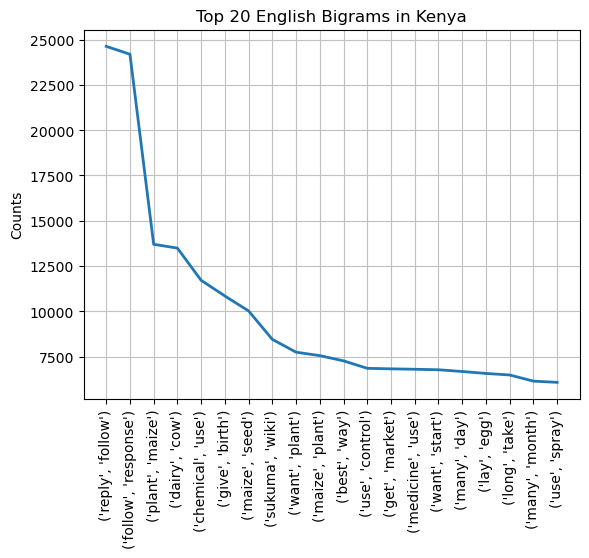

In [15]:
#plot frequency distribution of bigrams
fdist = FreqDist(all_bigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} English Bigrams in Kenya")
plt.xlabel("") 
plt.savefig("top20bigrams_ken_eng.png",bbox_inches='tight')

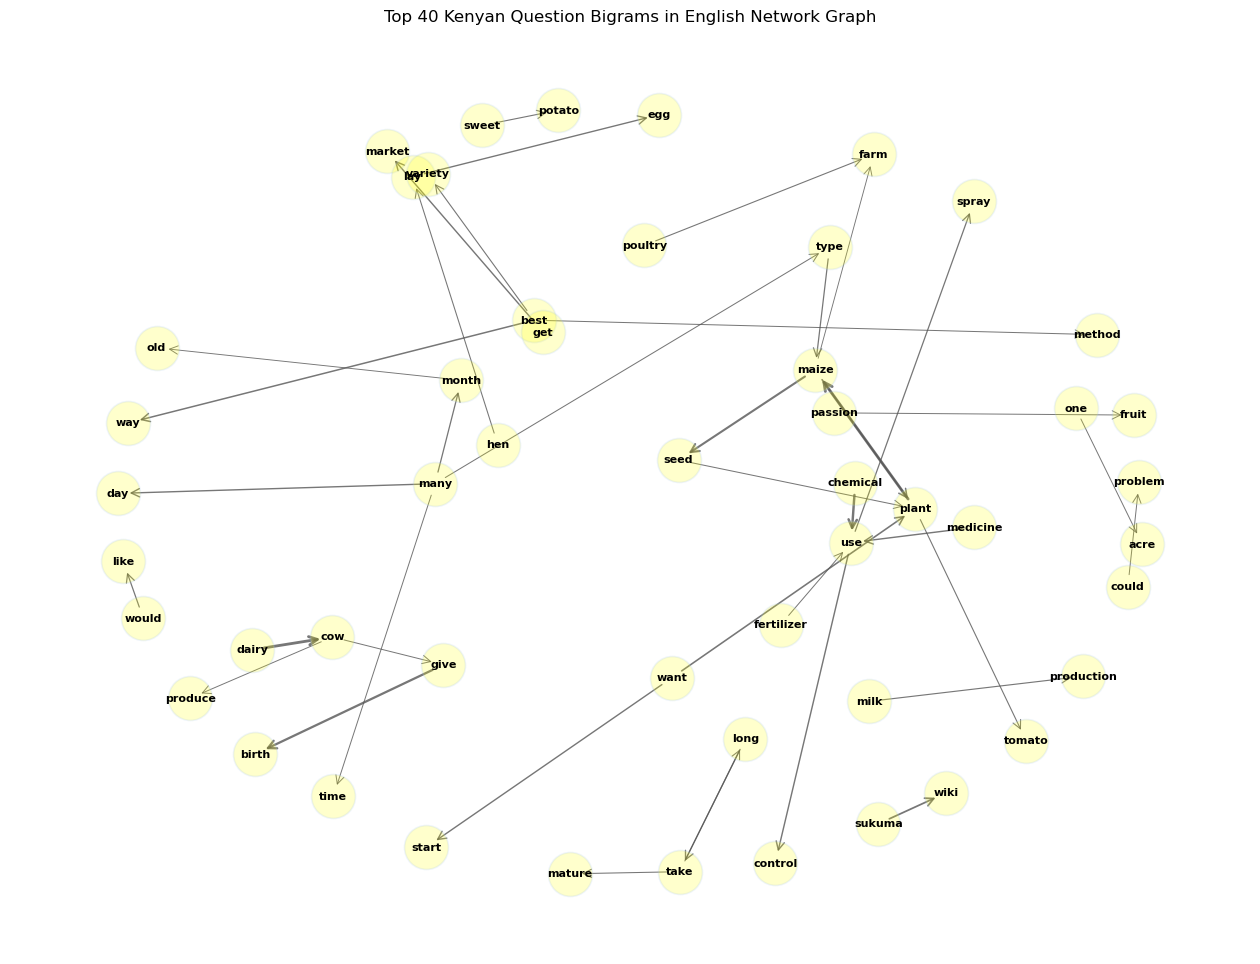

In [16]:
#create network diagram of bi-grams counter from bigram_freq, drop top 2 bigrams

#import networkx as nx

#choose most frequent N bigrams, after dropping first 2 bigrams:
top_n = 40
top_bigrams = bigram_freq.most_common()[2:top_n+2]
#----------------
#build network graph (Source:  chatgpt)
#G = nx.Graph()
G = nx.DiGraph()

for ((w1, w2), freq) in top_bigrams:
    G.add_edge(w1, w2, weight=freq/1000)
    
# ---------------------------
# Plot network graph
 
plt.figure(figsize=(16,12))

pos = nx.spring_layout(G, k=7.0, seed=42, iterations = 500)
#pos = nx.circular_layout(G)  # more spacing
#pos = nx.shell_layout(G)

# Node aesthetics
#nx.draw_networkx_nodes(G, pos, node_size=1500, alpha=0.9)
nx.draw_networkx_nodes(
    G, pos,
    node_size=1000,
    alpha=0.2,
    node_color="yellow",      
    edgecolors="#A7C7E7",   # soft blue
    linewidths=1.2
)

# Edges scaled by frequency
#weights = [G[u][v]['weight'] for u, v in G.edges()]
#nx.draw_networkx_edges(G, pos, width=[w for w in weights])
#nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in weights])

#edges scaled by frequency with arrows
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='->',
    arrowsize=15,
    width=[G[u][v]['weight'] * 0.15 for u, v in G.edges()],  # thin lines
    edge_color="#555555",
    alpha=0.8
)



# Labels
#nx.draw_networkx_labels(G, pos, font_size=7)
nx.draw_networkx_labels(
    G, pos,
    font_size=8,
    font_weight="bold"
)

plt.title("Top 40 Kenyan Question Bigrams in English Network Graph")
plt.axis("off")
plt.savefig("top40bigrams_ken_eng_network.png", dpi=300, bbox_inches="tight")
plt.show()

### Trigrams Frequency and Static Directed Network Graphs

##### plot frequency distribution of trigrams
fdist = FreqDist(all_trigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} English trigrams in Kenya")
plt.xlabel("") 
plt.savefig("top20trigrams_end_swa.png", bbox_inches='tight')

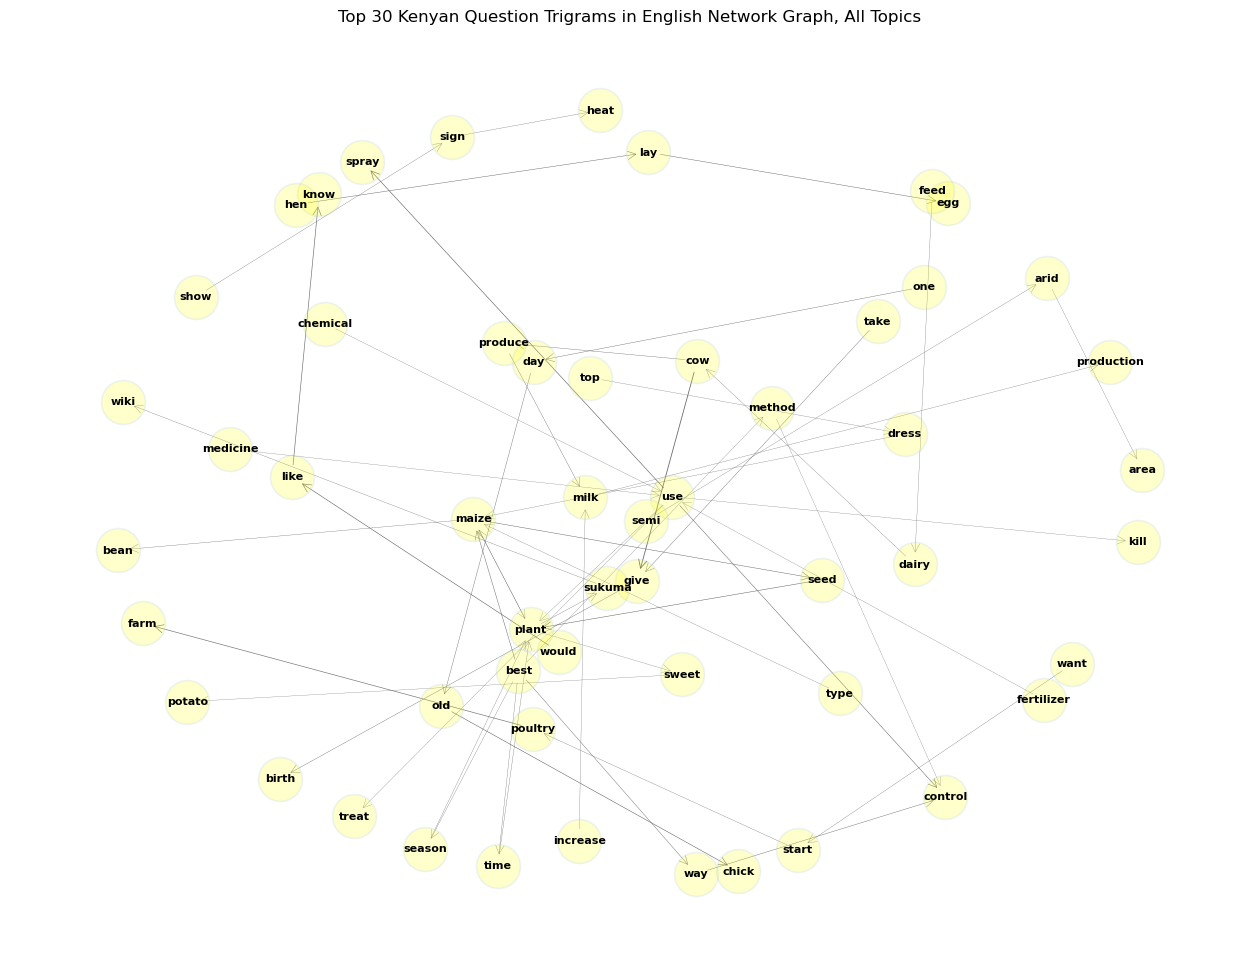

In [21]:
#create network diagram of tri-grams counter from trigram_freq, dropping 1st trigram

#import networkx as nx

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 30
top_trigrams = trigram_freq.most_common()[1:top_n+1]
#----------------
#build network graph (Source:  chatgpt)
#G = nx.Graph()
G = nx.DiGraph()

for (w1, w2, w3), freq in top_trigrams:
        # Add edges for each trigram
        G.add_edge(w1, w2, weight=freq/1000)
        G.add_edge(w2, w3, weight=freq/1000)
    
# ---------------------------
# Plot network graph
 
plt.figure(figsize=(16 , 12))

pos = nx.spring_layout(G, k=8.0, seed=42, iterations = 600)
#pos = nx.circular_layout(G)  # more spacing
#pos = nx.shell_layout(G)

# Node aesthetics
#nx.draw_networkx_nodes(G, pos, node_size=1500, alpha=0.9)
nx.draw_networkx_nodes(
    G, pos,
    node_size=1000,
    alpha=0.2,
    node_color="yellow",      
    edgecolors="#A7C7E7",   # soft blue
    linewidths=1.2
)

# Edges scaled by frequency
#weights = [G[u][v]['weight'] for u, v in G.edges()]
#nx.draw_networkx_edges(G, pos, width=[w for w in weights])
#nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in weights])

#edges scaled by frequency with arrows
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='->',
    arrowsize=15,
    width=[G[u][v]['weight'] * 0.2 for u, v in G.edges()],  # thin lines
    edge_color="#555555",
    alpha=0.85
)



# Labels
#nx.draw_networkx_labels(G, pos, font_size=7)
nx.draw_networkx_labels(
    G, pos,
    font_size=8,
    font_weight="bold"
)

plt.title("Top 30 Kenyan Question Trigrams in English Network Graph, All Topics")
plt.axis("off")
plt.savefig("top30trigrams_ken_eng_network.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
#find top 500 bigrams:
top_500 = bigram_freq.most_common(500)
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))

In [23]:
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))
ken_bigrams_500_df.head()

,bigram,count,bigram_str
0,"(reply, follow)",24631,reply_follow
1,"(follow, response)",24197,follow_response
2,"(plant, maize)",13700,plant_maize
3,"(dairy, cow)",13491,dairy_cow
4,"(chemical, use)",11712,chemical_use


In [24]:
#save in csv file:
ken_bigrams_500_df.to_csv('ken_eng_bigrams_top500.csv')


In [25]:
#find top 500 trigrams:
top_500 = trigram_freq.most_common(500)
#convert top_500 list to df, and join trigrams with '_' as separators for later translation, note: there are no duplicates
ken_trigrams_500_df = pd.DataFrame(top_500, columns=['trigram','count'])
ken_trigrams_500_df["trigram_str"] = ken_trigrams_500_df["trigram"].apply(lambda t: "_".join(t))
ken_trigrams_500_df.head()

,trigram,count,trigram_str
0,"(reply, follow, response)",24003,reply_follow_response
1,"(cow, give, birth)",3054,cow_give_birth
2,"(chemical, use, spray)",2340,chemical_use_spray
3,"(would, like, know)",2252,would_like_know
4,"(start, poultry, farm)",2214,start_poultry_farm


In [26]:
#save in csv file:
ken_trigrams_500_df.to_csv('ken_eng_trigrams_top500.csv')


In [27]:
#create list of quadgrams, after checking # tokens >= 4
#from nltk.util import ngrams

all_quadgrams = []

for question in ken_eng_tokens:
    if len(question) < 4:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_quadgrams.extend(list(ngrams(question,4)))
        


In [28]:
print("# of quadgrams: ", len(all_quadgrams))


# of quadgrams:  3765309


In [29]:
quadgram_freq = Counter(all_quadgrams)

### Quadgram Frequency Graph

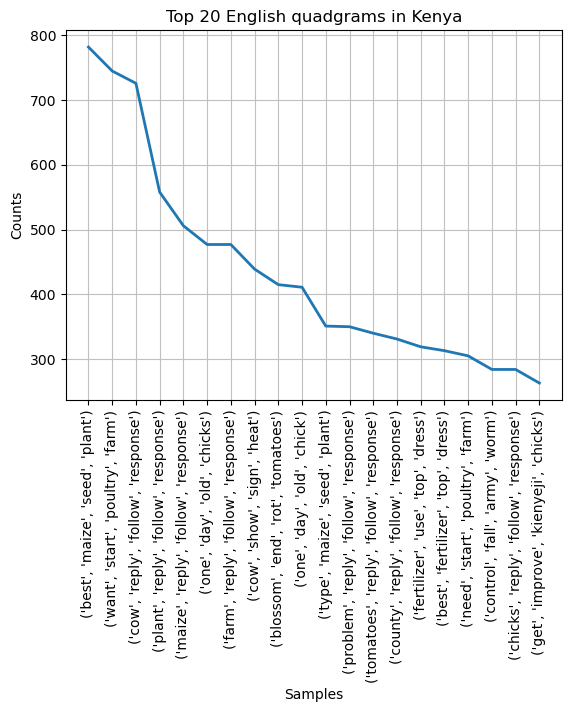

In [53]:
fdist = FreqDist(all_quadgrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} English quadgrams in Kenya")
plt.xlabel("") 
plt.savefig("top20quadgrams_ken_eng.png",bbox_inches='tight')

### Save top 500 n-grams in text files

In [30]:
#find top 500 quadgrams:
top_500 = quadgram_freq.most_common(500)
#convert top_500 list to df, and join quadgrams with '_' as separators for later translation, note: there are no duplicates
ken_quadgrams_500_df = pd.DataFrame(top_500, columns=['quadgram','count'])
ken_quadgrams_500_df["quadgram_str"] = ken_quadgrams_500_df["quadgram"].apply(lambda t: "_".join(t))

In [32]:
#save in csv file:
ken_quadgrams_500_df.to_csv('ken_eng_quadgrams_top500.csv')

In [33]:
#save n-gram strings only in text file:
ken_quadgrams_500_df['quadgram_str'].to_csv('ken_eng_quadgrams_top500.txt',header=None)
ken_bigrams_500_df['bigram_str'].to_csv('ken_eng_bigrams_top500.txt',header=None)
ken_trigrams_500_df['trigram_str'].to_csv('ken_eng_trigrams_top500.txt',header=None)